# Create plots for panels used in figure 2

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

Examples how to plot the control probability cure in figure 2A can be found in `plots_fig1`

## Panels B-D

In [2]:
#define a color seed for each patient
color_dict = {'VS': 'C0', 'VL': 'C1', 'RS': 'C2',
              'KM': 'C3', 'LM': 'C4'}

In [3]:
def logistic_growth(x, A, x_0, k):
    """The logistic growth fct"""
    return A/(1+np.exp(-k*(x-x_0)))

def deformed_probability_curve(df, v_min=0, v_max=3, binsize=.25):
    """Compute the values for the shape probability diagram to find a cell
    in a deformed state for velocities between v_min and v_max in the DataFrame df

    returns: *tuple* (deformed_bins, deformed_hist_normal)
        - deformed_bins: *array* limits for the bin ranges of the histogram
        - normalized counts for each velocity range
    """

    bins = int(v_max/binsize)   #number of Bins in histogram
    #find index of cells in a deformed state. Class definitions are:
    #1-parachute, 2-slipper, 3-asym. parachute, 5-multilobe, 7-undefined deformed
    #4-discocyte/undeformed, 6-tumbler
    deformed_index = ((df['shape'] == 1)
                      | (df['shape'] == 2)
                      | (df['shape'] == 3)
                      | (df['shape'] == 5)
                      | (df['shape'] == 7))

    #create new column in df that is True for deformed state
    df['deformed'] = False
    df['deformed'][deformed_index] = True

    df_deformed = df[deformed_index]

    deformed_hist, deformed_bins = np.histogram(np.array(df_deformed['velocity']),
                                                range = (v_min,v_max),
                                                bins = bins)
    #get the counts for all events to use for normalization
    all_hist, all_bins = np.histogram(np.array(df['velocity']),
                                      range = (v_min,v_max),
                                      bins = bins)

    #normalize the deformed histogram
    deformed_hist_normal = deformed_hist/all_hist

    return deformed_bins, deformed_hist_normal

In [4]:
#define dict to store fit values
dict_fitvalues = {}

def dict_fit_values_patient(patient, dict_fitvalues):
    result_summary_folder = r"C:\Users\freiche\ownCloud\PhD\Projects\ChAc\Analysis\Jupyter\MCFM\result_summaries"

    v_min = 0.
    v_max = 3.
    binsize = 0.25

    #bounds of the parameters in the logistic growth function for our example
    #f(x, A, x_0, k) = A/(1+np.exp(-k*(x-x_0)))
    # 0<A<1, 0<x_0<inf, 0<x_k<inf
    fit_bounds=(0, [1, np.inf, np.inf])

    result_file = os.path.join(result_summary_folder, patient + "_results_MCFM.tsv")
    df_results = pd.read_csv(result_file, sep='\t')

    dates = np.unique(df_results['date'])
    dates = np.sort(dates)
    day0 = pd.to_datetime(dates[0])

    #create dataframes to save fit parameters
    df_fit_all = pd.DataFrame()
    df_fit_healthy = pd.DataFrame()
    df_fit_unhealthy = pd.DataFrame()

    for num, date in enumerate(dates):
        df_date = df_results[df_results['date']==date]
        #create new Dataframe to work with, leave out skipped cells
        df = df_date[df_date['shape'] != 0]

        healthy_index = df['health'] == 0
        df_healthy = df[healthy_index]
        unhealthy_index = df['health'] == 1
        df_unhealthy = df[unhealthy_index]

        #calculate percentage of healthy cells in sample
        percentage_healthy = len(df_healthy)/len(df)

        bins, deformed_curve = deformed_probability_curve(df, v_min=v_min, v_max=v_max, binsize=binsize)
        bins_healthy, deformed_curve_healthy =  deformed_probability_curve(df_healthy,
                                                                           v_min=v_min, v_max=v_max, binsize=binsize)
        bins_unhealthy, deformed_curve_unhealthy =  deformed_probability_curve(df_unhealthy,
                                                                           v_min=v_min, v_max=v_max, binsize=binsize)

        bins_plot = bins[:-1]+binsize/2

        #exclude nan values before fitting
        ind_nonnan_all = ~np.isnan(deformed_curve)
        ind_nonnan_healthy = ~np.isnan(deformed_curve_healthy)
        ind_nonnan_unhealthy = ~np.isnan(deformed_curve_unhealthy)

        popt_all, pcov_all = curve_fit(logistic_growth,
                                       bins_plot[ind_nonnan_all], deformed_curve[ind_nonnan_all],
                                       bounds = fit_bounds)
        popt_healthy, pcov_healthy = curve_fit(logistic_growth, bins_plot[ind_nonnan_healthy],
                                               deformed_curve_healthy[ind_nonnan_healthy],
                                               bounds = fit_bounds)
        popt_unhealthy, pcov_unhealthy = curve_fit(logistic_growth, bins_plot[ind_nonnan_unhealthy],
                                                   deformed_curve_unhealthy[ind_nonnan_unhealthy],
                                                   bounds = fit_bounds)

        #days since treatment start
        treatment_days = (pd.to_datetime(date) - day0).days

        df_fit_all = df_fit_all.append({'A': popt_all[0], 'x0': popt_all[1],
                                        'k': popt_all[2], 'days': treatment_days,
                                        'percent healthy': percentage_healthy},
                                       ignore_index=True)
        df_fit_healthy = df_fit_healthy.append({'A': popt_healthy[0],
                                           'x0': popt_healthy[1],
                                           'k': popt_healthy[2],
                                            'days': treatment_days}, ignore_index=True)
        df_fit_unhealthy = df_fit_unhealthy.append({'A': popt_unhealthy[0],
                                             'x0': popt_unhealthy[1],
                                             'k': popt_unhealthy[2],
                                              'days': treatment_days}, ignore_index=True)

    dict_fitvalues[patient] = {'all': df_fit_all, 'healthy': df_fit_healthy, 'unhealthy': df_fit_unhealthy}

    return dict_fitvalues

Fill dictionary with patient data

In [5]:
patients = ['VS', 'VL', 'RS', 'LM', 'KM']
labels = ["P1", "P2", "P3", "P4", "P5"]

for patient in patients:
    dict_fitvalues = dict_fit_values_patient(patient, dict_fitvalues)

Plot data for P1-P3

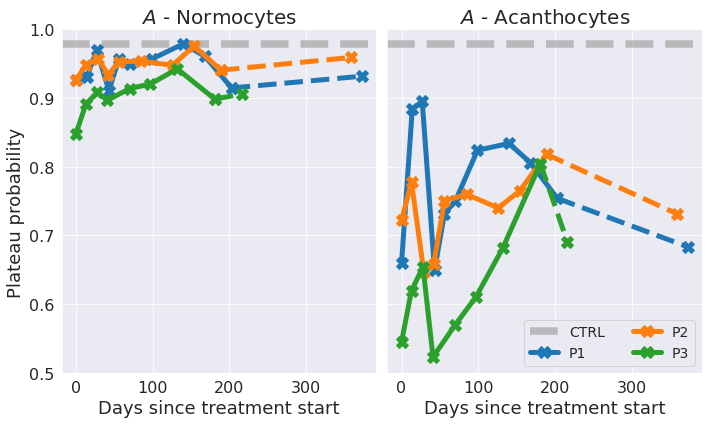

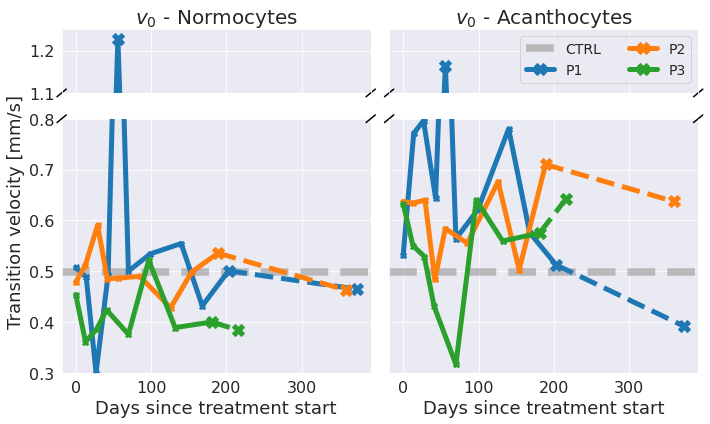

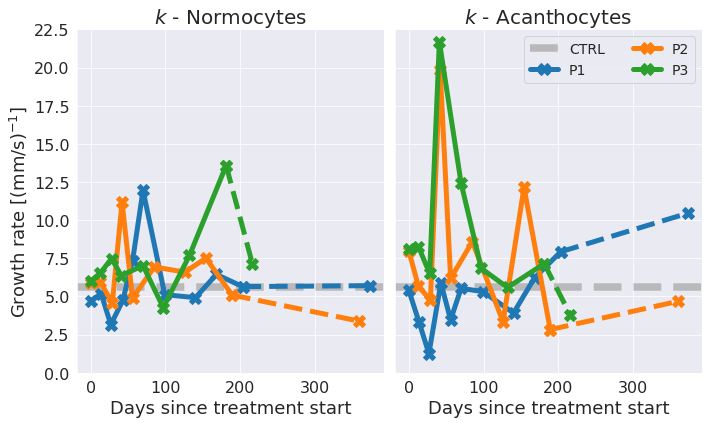

In [6]:
patients = ['VS', 'VL', 'RS']
labels = ["P1", "P2", "P3"]
savefolder = r"C:\Users\freiche\ownCloud\PhD\Projects\ChAc\manuscript\figures\plots\MCFM"

# plot variables
fontsize = 18
linewidth = 5
markersize = 12
xlabel = 'Days since treatment start'

# compute control fit values
results_ctrl = np.loadtxt("histograms_HealthyControl_deformed_undeformed.txt")

v_ctrl = results_ctrl[:,0]
probs_ctrl = results_ctrl[:,3]
probs_ctrl_err = results_ctrl[:,4]

fit_bounds=(0, [1, np.inf, np.inf])

v_min = 0.
v_max = 3.
binsize = 0.25
bins = int(v_max / binsize)

ind_vmax = v_ctrl <= v_max
v_ctrl = v_ctrl[ind_vmax]
probs_ctrl = probs_ctrl[ind_vmax]
probs_ctrl_err = probs_ctrl_err[ind_vmax]

popt_ctrl, pcov_ctrl = curve_fit(logistic_growth, v_ctrl, probs_ctrl,
                                 sigma = probs_ctrl_err, absolute_sigma=False,
                                 bounds = fit_bounds)

with sns.axes_style('darkgrid'):

    # plot control values in every plot
    for ii in range(3):
        if ii==1:
            plt.figure(ii,(10,6))
        else:
            plt.figure(ii,(10,6))

    fig = plt.figure(1,(11,6))
    height_ratio = 4
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, height_ratios=[1,height_ratio])

    params = ['A', 'x0', 'k']
    plot_titles = ['Normocytes', 'Acanthocytes']
    ylims = [(.5,1), (.3,.85),(0,22.5)]

    for jj, patient in enumerate(patients):
        data = dict_fitvalues[patient]
        color = color_dict[patient]

        for ii in range(len(params)):
            para = params[ii]
            fig = plt.figure(ii)

            for n, health in enumerate(['healthy', 'unhealthy']):
                df_plot = data[health]
                if para=='x0':
                    ax1=plt.subplot(spec[0, n])
                    ax2=plt.subplot(spec[1, n])

                    if jj==0:
                        ax1.set_title(r'${}$ - {}'.format("v_0", plot_titles[n]), fontsize=fontsize+2)
                        # hide the spines between ax1 and ax2
                        ax1.spines['bottom'].set_visible(False)
                        ax2.spines['top'].set_visible(False)
                        ax1.tick_params(labeltop=False, labelbottom=False)  # don't put tick labels at the top

                        d = .015  # how big to make the diagonal lines in axes coordinates
                        # arguments to pass to plot, just so we don't keep repeating them
                        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
                        ax1.plot((-d, +d), (-height_ratio*d, +height_ratio*d), **kwargs)        # top-left diagonal
                        ax1.plot((1 - d, 1 + d), (-height_ratio*d, +height_ratio*d), **kwargs)  # top-right diagonal

                        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
                        ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
                        ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

                        ax1.set_ylim(1.1,1.25)
                        ax2.set_ylim(.3,.8)
                        ax2.set_xlabel(xlabel, fontsize=fontsize)

                        ax1.tick_params(axis='both', which='both', labelsize=fontsize-2)
                        ax1.set_xticks([0,100,200,300])
                        ax2.tick_params(axis='both', which='both', labelsize=fontsize-2)
                        ax2.set_xticks([0,100,200,300])

                        if health=='unhealthy':
                            ax2.axhline(popt_ctrl[ii], color='darkgray', ls='--',
                                        lw=1.5*linewidth, alpha=.75, label='CTRL')
                            ax1.axhline(popt_ctrl[ii], color='darkgray', ls='--',
                                        lw=1.5*linewidth, alpha=.75, label='CTRL')
                        else:
                            ax2.axhline(popt_ctrl[ii], color='darkgray', ls='--',
                                        lw=1.5*linewidth, alpha=.75, label='CTRL')

                    ax1.plot(df_plot['days'][:-1], df_plot[para][:-1], c=color, label=labels[jj],
                             marker='X', lw=linewidth, markersize=markersize)
                    ax1.plot(df_plot['days'][-2:], df_plot[para][-2:], '--', c=color,
                             marker='X', lw=linewidth, markersize=markersize)
                    ax2.plot(df_plot['days'][:-1], df_plot[para][:-1], c=color, label=labels[jj],
                             marker='X', lw=linewidth)
                    ax2.plot(df_plot['days'][-2:], df_plot[para][-2:], '--', c=color,
                             marker='X', lw=linewidth, markersize=markersize)

                    if patient == 'RS' and health=='unhealthy':
                        ax1.legend(ncol=2, fontsize=fontsize-4)

                    if health=='unhealthy':
                        ax1.get_yaxis().set_ticklabels([])
                        ax2.get_yaxis().set_ticklabels([])

                else:
                    ax=plt.subplot(1,2,n+1)

                    if jj==0:
                        if health=='unhealthy':
                            plt.axhline(popt_ctrl[ii], color='darkgray', ls='--',
                                        lw=1.5*linewidth, alpha=.75, label='CTRL')
                        else:
                            plt.axhline(popt_ctrl[ii], color='darkgray', ls='--',
                                        lw=1.5*linewidth, alpha=.75)

                    plt.plot(df_plot['days'][:-1], df_plot[para][:-1], c=color, label=labels[jj],
                             marker='X', lw=linewidth, markersize=markersize)
                    plt.plot(df_plot['days'][-2:], df_plot[para][-2:], '--', c=color,
                             marker='X', lw=linewidth, markersize=markersize)

                    plt.ylim(ylims[ii])
                    plt.xlabel(xlabel, fontsize=fontsize)
                    plt.tick_params(axis='both', which='both', labelsize=fontsize-2)
                    plt.xticks([0,100,200,300])
                    plt.title(r'${}$ - {}'.format(para, plot_titles[n]), fontsize=fontsize+2)

                    if health=='unhealthy':
                        ax.get_yaxis().set_ticklabels([])

    fig = plt.figure(0)
    fig.supylabel("Plateau probability", fontsize=fontsize)
    plt.legend(ncol=2, fontsize=fontsize-4, title_fontsize=fontsize)
    plt.tight_layout()
    savename = "MCFM_treatment_fitvalues_A_fig2"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')

    fig=plt.figure(1)
    fig.supylabel("Transition velocity [mm/s]", fontsize=fontsize)
    plt.tight_layout()
    savename = "MCFM_treatment_fitvalues_v0_fig2"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')

    fig = plt.figure(2)
    fig.supylabel(r"Growth rate [(mm/s)$^{-1}$]", fontsize=fontsize)
    plt.legend(ncol=2, fontsize=fontsize-4, title_fontsize=fontsize)
    plt.tight_layout()
    savename = "MCFM_treatment_fitvalues_k_fig2"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')

## Panel E

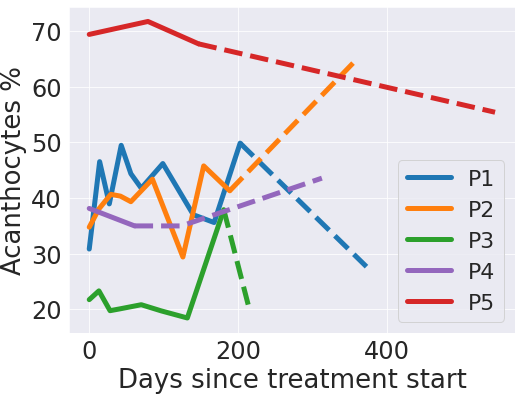

In [9]:
patients = ['VS', 'VL', 'RS', 'LM', 'KM']
labels = ["P1", "P2", "P3", "P4", "P5"]
savefolder = r"C:\Users\freiche\ownCloud\PhD\Projects\ChAc\manuscript\figures\plots\MCFM"

fontsize = 24
lw = 5
xlabel = 'Days since treatment start'

with sns.axes_style('darkgrid'):
    plt.figure(0,(8,6))

    for jj, patient in enumerate(patients):
        data = dict_fitvalues[patient]
        color = color_dict[patient]

        # plot percentage of acanthocytes
        df_all = data['all']

        if patient=='LM':
            plt.plot(df_all['days'][:-2], (1-df_all['percent healthy'][:-2])*100, c=color, lw=lw, label=labels[jj])
            plt.plot(df_all['days'][-3:], (1-df_all['percent healthy'][-3:])*100, '--', lw=lw, c=color)
        else:
            plt.plot(df_all['days'][:-1], (1-df_all['percent healthy'][:-1])*100, c=color, lw=lw, label=labels[jj])
            plt.plot(df_all['days'][-2:], (1-df_all['percent healthy'][-2:])*100, '--', lw=lw, c=color)

    plt.ylim(0,100)
    plt.xlabel(xlabel, fontsize=fontsize+2)
    plt.ylabel("Acanthocytes %", fontsize=fontsize+2)
    plt.tick_params(axis='both', which='both', labelsize=fontsize)

    plt.figure(0)
    plt.autoscale()
    plt.legend(fontsize=fontsize-2, ncol=1)
    savename = "MCFM_treatment_acantho_count"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')

## Panel F

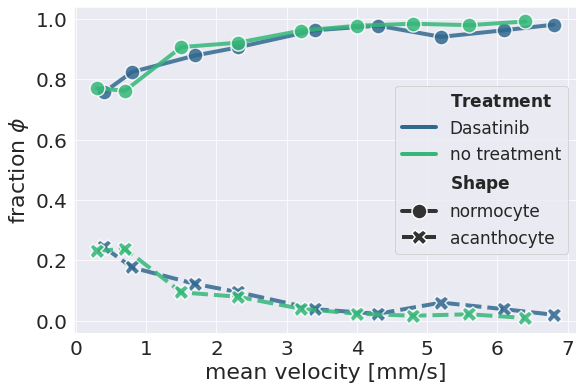

In [8]:
# read in vitro study data
path_in_vitro = "data_in_vitro_dasa_treatment.xlsx"
df_in_vitro = pd.read_excel(path_in_vitro)

# plot parameters
linewidth = 4
markersize = 15
markerwidth = 1.5
fontsize = 20

markers = 'treatment'
with sns.axes_style('darkgrid'):
    fig = plt.figure(0,(9,6))
    ax = plt.subplot(111)

    sns.lineplot(x='mean velocity [mm/s]', y='fraction', data=df_in_vitro,
                 hue='treatment', style='shape', markers=True,
                 ax=ax, palette='viridis',
                 linewidth=linewidth, markersize=markersize, markeredgewidth=markerwidth,
                 alpha=.85
                 )

    ax.xaxis.label.set_size(fontsize+2)
    ax.set_ylabel(r"fraction $\phi$", fontsize=fontsize+2)
    ax.tick_params(axis='both', labelsize=fontsize)

    handles, labels = ax.get_legend_handles_labels()
    label = r"$\bf{Treatment}$"
    labels[0] = label
    labels[3] = r"$\bf{Shape}$"

    handles_new = []
    for handle in handles:
        if handle.get_color() == 'w':
            handle.set_linewidth(0)
        else:
            handle.set_linewidth(linewidth)
        handle.set(markersize=markersize,
                   markeredgewidth=markerwidth,
                   markeredgecolor='w')
        handles_new.append(handle)

    leg = plt.legend(handles_new, labels, ncol=1, fontsize=fontsize-3)